# Welcome

## Homework #2. Practice

Author: [Nikita Balabin](mailto:nikita.balabin@skoltech.ru)

In this task, you are asked to be a bit bayesian (also, you can see: https://arxiv.org/abs/2002.10118). We consider the nice dataset: pictures with animal faces. It could be found and downloaded here: https://www.kaggle.com/andrewmvd/animal-faces and contain 3 classes of images: cat, dog and wild. The deep neural networks are known to be overconfient, so we make some attempts to mitigate this problem.

1. We start from the ordinary training of the NN.
2. Then we consider the Laplace approximation of the trained NN. The advantage of the such approach is that we did not change the training procedure.
3. Finaly, we consider the training with ELBO optimization in order to find the gaussian posterior.

<img src='img_for_task/intro.png'  width="40%" height="40%">

As the feature extractor $\phi(x)$ for this problem we will use ResNet18 ```torchvision.models.resnet18(pretrained=True)``` and train only the last FC layer.

#### Links of problems:
[Problem 1](#problem1) 10 points

[Problem 2](#problem2) 20points

[Problem 3](#problem3) 20 points 

------ Total : 50 points  -------

In [1]:
from google.colab import drive
drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [2]:
cd /content/MyDrive/MyDrive/Skoltech/Bayesian/

/content/MyDrive/MyDrive/Skoltech/Bayesian


In [1]:
import os
import pandas as pd
# from torchvision.io import read_image
import torchvision
from tqdm import tqdm
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
train_dataset = torchvision.datasets.ImageFolder('afhq/train', transform = torchvision.transforms.ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=24, shuffle=True)

test_dataset = torchvision.datasets.ImageFolder('afhq/val', transform = torchvision.transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=24, shuffle=True)

device = 'cuda'

In [2]:
model = torchvision.models.resnet18(pretrained=True).to(device)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(512, 3, bias = False)


### Model

Consider dataset

$$
\begin{aligned}
& \{(x_n, y_n)\}_{n=1}^{N} \\
& x_n\in\mathbb{R}^{3\times D\times D} \text{ animal face images} \\
& y_n\in\{1,2,3\} \text{ labels}
\end{aligned}
$$

To model probability output we consider linear layer + soft-max on top of the feature extractor $\phi(x)$.

$$
\begin{aligned}
& p(y_n=i|x_n, W) = \text{Softmax}(W\phi(x), i)
\end{aligned}
$$



Also we put the prior distribution over the $W$, $\pi(W) = \mathcal{N}(\text{vec}(W)|\vec{0},A^{-1})$, where matrix $A$ is diagonal.

<a id='problem1'></a>
#### Problem 1 (10 points)
1. Fix $A$. You can think of it as a $l2$ regulariazation coefficient. Find MAP estimate of $W$, so that the accuracy of the model on the validation set is **more** than $95\%$.

2. Classify some out of the distriubtion pictures. For example, photos of cars or a cartoon character or something else that enjoy. Plot them with predicted class label and probability.  

3. Make the histogram of the top-class probability over the test set.

1. Let's split $\mathbf{W}$ into $\left[\mathbf{w}_1, \mathbf{w}_2, \mathbf{w}_3 \right]$, where $\mathbf{w}_i$ corresponds to $i$-th label. Then posterior 
$$
P\left(\mathbf{W}_i | Y \right) = \prod \limits_{n=1}^N \frac{P\left(y_n = i| \mathbf{w}_i \right)  P\left(\mathbf{w}_i \right)}{P\left(y_n \right)}
$$
To found MAP estimate, we formulate gradient ascent for log of posterior:
$$
\nabla \log P\left(\mathbf{w}_i | Y \right) = \nabla_{\mathbf{w}_i} \sum \limits_{n  : y_n = i} \left[ \mathbf{w}_i^\top \phi\left(x_n \right) - \log \sum \limits_{j=1}^3 e ^ {\mathbf{w}_j^\top \phi\left(x_n \right)} \right]- \frac{1}{2} \mathbf{w}_i ^\top  A_i \mathbf{w}_i  = \\
= \sum \limits_{n  : y_n = i} \phi\left(x_n \right)\left[1 - \frac{e ^ {\mathbf{w}_i^\top \phi\left(x_n \right)}}{\sum \limits_{j=1}^3 e ^ {\mathbf{w}_j^\top \phi\left(x_n \right)}} \right]  -   A_i \mathbf{w}_i
$$

In [3]:
class Net(nn.Module):
    def __init__(self, model, a):
        super().__init__()
        self.backbone = model
#         self.fc1 = nn.Linear(1000, 3, bias = False)
#         torch.nn.init.normal_(self.fc1.weight, std = 1 / a)

    def forward(self, x):
        x = self.backbone(x)
#         x = self.fc1(x)
#         x = F.softmax(x, dim = 1)
        return x

a =1e-2
net = Net(model, a).to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay = a ** 2)

Since $\log P(\mathbf{W} | y) \sim \log P(Y | \mathbf{W}, X) + \log P(\mathbf{W})$, 

the $\mathbf{W}_{MAP}$ could be found through minimization of cross entropy loss and L2 regularization.

In [21]:
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    t = tqdm(train_dataloader)
    for data in  t:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        t.set_description(f'current loss : {loss.item() :.3f}' )
    print(running_loss)

print('Finished Training')

  0%|                                                                                          | 0/610 [00:00<?, ?it/s]

92.96673373691738


  0%|                                                                                          | 0/610 [00:00<?, ?it/s]

51.08437545783818


  0%|                                                                                          | 0/610 [00:00<?, ?it/s]

40.34702383261174


  0%|                                                                                          | 0/610 [00:00<?, ?it/s]

35.85772111127153


current loss : 0.014: 100%|██████████████████████████████████████████████████████████| 610/610 [05:50<00:00,  1.74it/s]

33.07642608508468
Finished Training


In [23]:
torch.save(net.state_dict(), 'model_resnet.pt')

In [4]:


# new_net = Net(model, a)
# new_net.load_state_dict(torch.load('model_resnet.pt'))
# new_net.eval()

### Let's check the accuracy

In [5]:
new_net = Net(model, a)
new_net.load_state_dict(torch.load('model_resnet.pt'))
t = tqdm(test_dataloader)
acc = 0
with torch.no_grad():
    new_net.eval()
    for data in t:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        y_pred = new_net(inputs).argmax(dim = 1)
        acc += torch.sum(y_pred == labels)

total_acc = acc / len(test_dataset)    

print(total_acc)

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.26it/s]

tensor(0.9900, device='cuda:0')


In [77]:
print(f' W MAP is {W.data.cpu().detach().numpy()}')

 W MAP is [-0.1276687  -0.14376031 -0.07811577 ...  0.09024782 -0.12054057
 -0.10380331]


## Let's look at in- and out of distribuion samples
### In

In [19]:
# visualisation was taken from kaggle
def imshow(inp, title=None):
    inp = inp.cpu().detach().numpy().transpose((1, 2, 0))
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [103]:

    
im, lab = next(iter(test_dataloader))
label_map = {0 : 'cat', 1 : 'dog', 2 : 'wild'}
inputs = im#[0]
labels = lab#[0]
inputs = inputs.to(device)
labels = labels.to(device)
outputs = new_net(inputs)
_, preds = torch.max(outputs, 1)


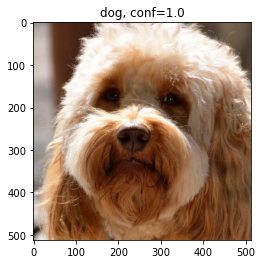

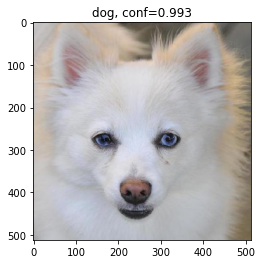

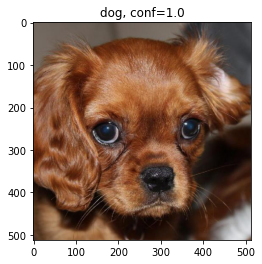

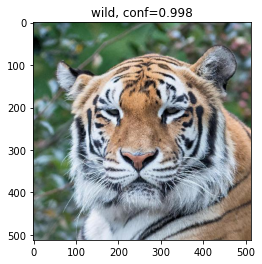

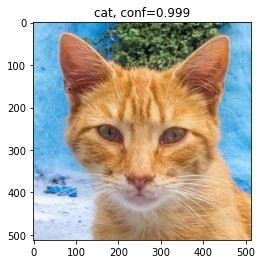

In [104]:
for i in range(5):
    title = label_map[int(preds[i].cpu())] +', conf=' +  str(round(float(nn.Softmax(dim=0)(outputs[i])[preds[i]]), 3))
    imshow(inputs[i], title = title)

### Out

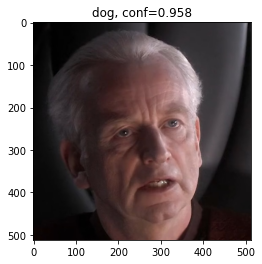

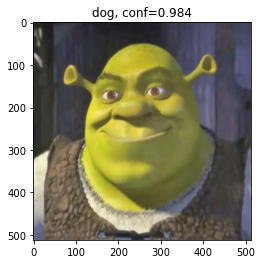

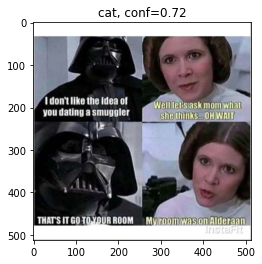

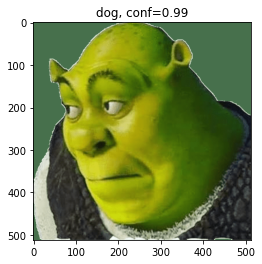

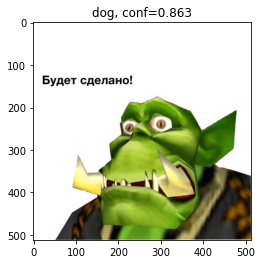

In [105]:
out_dataset = torchvision.datasets.ImageFolder('afhq/out', transform = torchvision.transforms.ToTensor())
out_dataloader = DataLoader(out_dataset, batch_size=5, shuffle=True)

im, lab = next(iter(out_dataloader))
label_map = {0 : 'cat', 1 : 'dog', 2 : 'wild'}
inputs = im#[0]
labels = lab#[0]
inputs = inputs.to(device)
labels = labels.to(device)
outputs = new_net(inputs)
_, preds = torch.max(outputs, 1)

for i in range(5):
    title = label_map[int(preds[i].cpu())] +', conf=' +  str(round(float(nn.Softmax(dim=0)(outputs[i])[preds[i]]), 3))
    imshow(inputs[i], title = title)

As we can see, while the model gives correct answer with high confidence on in-distribution samples, it is also overconfident in classifying out of distribution samples

## Histograms

In [41]:
model.fc.weight

Parameter containing:
tensor([[-0.1277, -0.1438, -0.0781,  ..., -0.0019, -0.0289,  0.1150],
        [ 0.1333,  0.1123,  0.1185,  ..., -0.1123,  0.1735, -0.0529],
        [-0.0878,  0.0033, -0.0287,  ...,  0.0902, -0.1205, -0.1038]],
       device='cuda:0', requires_grad=True)

In [38]:
probs = []
with torch.no_grad():
    new_net.eval()
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = new_net(inputs)
        val, preds = torch.max(nn.Softmax(dim=1)(outputs), dim=1)
        probs += val


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:16<00:00,  3.77it/s]


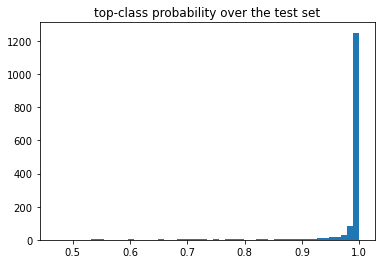

In [39]:
q = torch.tensor(probs)
plt.hist(q.numpy(), bins=50)
plt.title('top-class probability over the test set')
plt.show()

## 2 problem

<a id='problem2'></a>
#### Problem 2, (20 points)
1. Consider the Laplace approximation of the posterior and approximation of the posterior-predictive distribution of the trained model. As Hessian consider two options:
    - full hessian
    - only diagonal part

2. Re-do point 2. and 3. from Problem 1 and compare results between full-Laplace, diagonal part-Laplace and just MAP.

In [6]:
feature_extr = nn.Sequential(*list(model.children())[:-1])
# feature_extr(inputs).shape
# out2 = feature_extr(inputs)

In [58]:
def loss_object(weight, inputs, labels):
    W = torch.vstack((weight[:512], weight[512: 1024], weight[1024:]))
    phi = feature_extr(inputs)
    outputs = phi.reshape(-1, W.shape[1]) @ W.T
    loss = criterion(outputs, labels)
    return (loss + torch.norm(W) ** 2 * a ** 2) / inputs.shape[0]

In [59]:
W = new_net.backbone.fc.weight.reshape(-1)
Hessian = torch.zeros((512*3, 512*3)).to(device)
result = 0
hessian_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# N = len(hessian_dataloader)
t = tqdm(hessian_dataloader)
for data in  t:
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    H = torch.tensor(torch.autograd.functional.hessian(lambda x : loss_object(x, inputs, labels), W, create_graph=True))
    Hessian += H

  0%|                                                                                          | 0/229 [00:00<?, ?it/s]D:\programs\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [12:37<00:00,  3.31s/it]


In [56]:
W

tensor([-0.1277, -0.1438, -0.0781,  ...,  0.0902, -0.1205, -0.1038],
       device='cuda:0', grad_fn=<ViewBackward>)

In [60]:
cov_matrix_full = Hessian.clone() #torch.linalg.inv()
cov_matrix_diag = torch.diag(torch.diagonal(Hessian))

### Full matrix

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.34it/s]


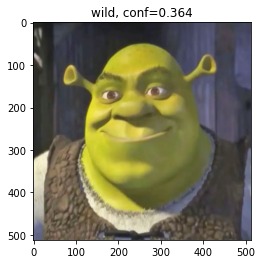

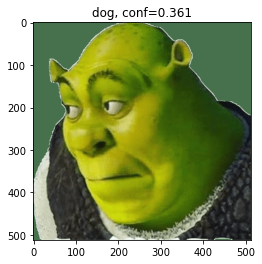

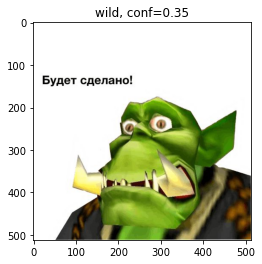

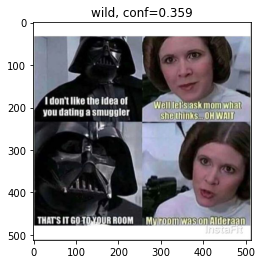

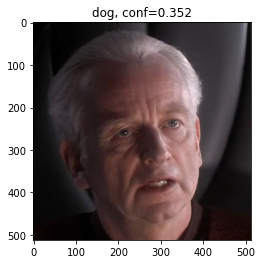

In [65]:
dist = torch.distributions.multivariate_normal.MultivariateNormal(W, cov_matrix_full)
out_dataset = torchvision.datasets.ImageFolder('afhq/out', transform = torchvision.transforms.ToTensor())
out_dataloader = DataLoader(out_dataset, batch_size=5, shuffle=True)

im, lab = next(iter(out_dataloader))
label_map = {0 : 'cat', 1 : 'dog', 2 : 'wild'}
inputs = im#[0]
labels = lab#[0]
inputs = inputs.to(device)
labels = labels.to(device)
samples = dist.sample(sample_shape = torch.tensor([100]))
outputs = torch.zeros((100, inputs.shape[0], 3))

for k in tqdm(range(100)):
    cur_W = torch.vstack((samples[k][:512], samples[k][512: 1024], samples[k][1024:]))
    phi = feature_extr(inputs)
    outputs[k] = nn.Softmax()(phi.reshape(-1, cur_W.shape[1]) @ cur_W.T)


_, preds = torch.max(outputs.mean(axis=0), 1)

for i in range(5):
    title = label_map[int(preds[i].cpu())] +', conf=' +  str(round(float((outputs.mean(axis=0)[i])[preds[i]]), 3))
    imshow(inputs[i], title = title)

In [67]:
probs = []
dist = torch.distributions.multivariate_normal.MultivariateNormal(W, cov_matrix_full)

with torch.no_grad():
    new_net.eval()
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.zeros((100, inputs.shape[0], 3))
        samples = dist.sample(sample_shape = torch.tensor([100]))
        
        for k in (range(100)):
            cur_W = torch.vstack((samples[k][:512], samples[k][512: 1024], samples[k][1024:]))
            phi = feature_extr(inputs)
            outputs[k] = nn.Softmax()(phi.reshape(-1, cur_W.shape[1]) @ cur_W.T)
        
        outputs = outputs.mean(axis=0)
        val, preds = torch.max(outputs, dim=1)
        probs += val


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]D:\programs\Anaconda\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [30:01<00:00, 28.59s/it]


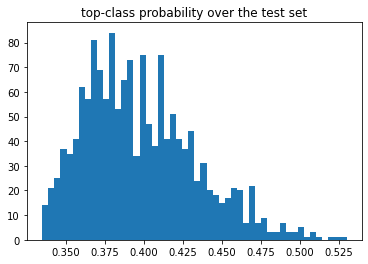

In [68]:
q = torch.tensor(probs)
plt.hist(q.numpy(), bins=50)
plt.title('top-class probability over the test set')
plt.show()

### Diagonal matrix

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.42it/s]


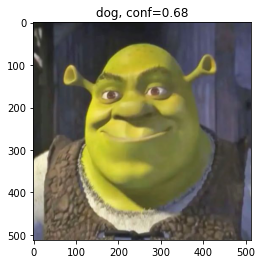

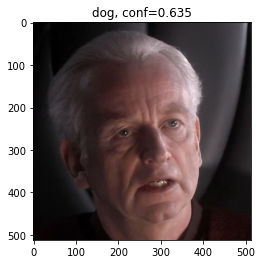

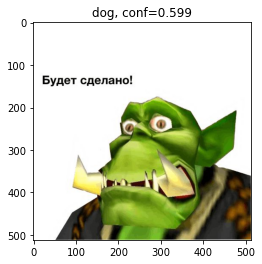

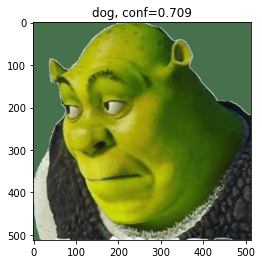

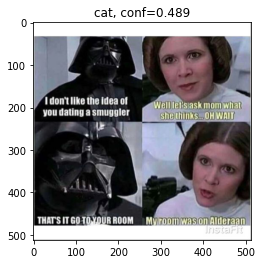

In [69]:
dist = torch.distributions.multivariate_normal.MultivariateNormal(W, cov_matrix_diag)
out_dataset = torchvision.datasets.ImageFolder('afhq/out', transform = torchvision.transforms.ToTensor())
out_dataloader = DataLoader(out_dataset, batch_size=5, shuffle=True)

im, lab = next(iter(out_dataloader))
label_map = {0 : 'cat', 1 : 'dog', 2 : 'wild'}
inputs = im#[0]
labels = lab#[0]
inputs = inputs.to(device)
labels = labels.to(device)
samples = dist.sample(sample_shape = torch.tensor([100]))
outputs = torch.zeros((100, inputs.shape[0], 3))

for k in tqdm(range(100)):
    cur_W = torch.vstack((samples[k][:512], samples[k][512: 1024], samples[k][1024:]))
    phi = feature_extr(inputs)
    outputs[k] = nn.Softmax()(phi.reshape(-1, cur_W.shape[1]) @ cur_W.T)


_, preds = torch.max(outputs.mean(axis=0), 1)

for i in range(5):
    title = label_map[int(preds[i].cpu())] +', conf=' +  str(round(float((outputs.mean(axis=0)[i])[preds[i]]), 3))
    imshow(inputs[i], title = title)

In [70]:
probs = []
dist = torch.distributions.multivariate_normal.MultivariateNormal(W, cov_matrix_diag)

with torch.no_grad():
    new_net.eval()
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.zeros((100, inputs.shape[0], 3))
        samples = dist.sample(sample_shape = torch.tensor([100]))
        
        for k in (range(100)):
            cur_W = torch.vstack((samples[k][:512], samples[k][512: 1024], samples[k][1024:]))
            phi = feature_extr(inputs)
            outputs[k] = nn.Softmax()(phi.reshape(-1, cur_W.shape[1]) @ cur_W.T)
        
        outputs = outputs.mean(axis=0)
        val, preds = torch.max(outputs, dim=1)
        probs += val


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]D:\programs\Anaconda\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [30:11<00:00, 28.75s/it]


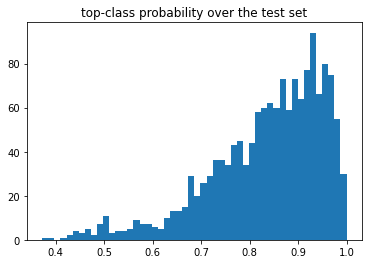

In [71]:
q = torch.tensor(probs)
plt.hist(q.numpy(), bins=50)
plt.title('top-class probability over the test set')
plt.show()

So we can see that using full hessian makes confidence on out of distribution images decrease, but that holds for in distribution images too. So the model becomes less confident in general. At the same time using diagonal hessian allows to see low confidence on out of distribution samples, whereas preserving the high confidence on in distribution objects.

<a id='problem3'></a>
#### Problem 3, (20 points)

$$
p(Y,W|X,A) = \left[\prod\limits_{n=1}^{N}p(y_n|x_n, W)\right]\mathcal{N}(\text{vec}(W)|\vec{0},A^{-1}).
$$

And we want to optimise ELBO with variational distribution $q$:

$$
\mathcal{L}[q, A] = \int q(W)\log\frac{p(y,W|x,A)}{q(W)}dW.
$$

Let's make the following assumptions:

$$
\begin{aligned}
& q(W) = \mathcal{N}(\text{vec}(W)|m,S) \\
\end{aligned}
$$
 
The plan for the solution is the following: 
 
  1. Derive the equation for $\mathcal{L}[m, S, A]$, take all expectations that can be taken analytically. Here, again consider two options:
      - Train diagonal $S$
      - Train full covariance matrix $S$
  2. From first order condition find optimal $\alpha^{i}$ (diagonal elements of $A$).
  3. Derive the equation for $\mathcal{L}[m, S]$ by pluging-in optimal $A$. 
 
Re-do point 2. and 3. from Problem 1 above and compare results.